In [1]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.trainer import Trainer
from src.optimizers.gibo import GIBOptimizer
from src.optimizers.vanilla_bo import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gym/envs/registration.py:415: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
pybullet build time: Jun 23 2022 12:25:14


In [2]:
env_name = "CartPole-v1"
#env_name = "Swimmer-v4"
kernel_name = "rbfstate" ## "linearstate" /"rbfstate"

env_config,likelihood_config,kernel_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name)
additional_layers=[] ### can be empty or [8,7] for adding 2 layers with width 8,7 respectively

optimizer_config = {
        "n_eval":1, ## 3 for cartpole (very noisy)
        ### for GIBO
        "n_max":20, 
        "n_info_samples":8,
        "delta":0.1, ## 0.01 for cartpole
        ### hessian normalisation applies only for rbf
        "normalize_gradient":True if kernel_name == "rbf" else False,
        "standard_deviation_scaling":False,
}

likelihood_config = {
                "noise_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=0.01,b=0.101),
                "noise_constraint":gpytorch.constraints.constraints.Interval(0.01,0.101)
                }

# kernel_config = {
#         "use_ard":False,
#         "kernel_name":kernel_name,
#         #lengthscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(5,0.9),
#         #"lengthscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.1),
#         #"outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.1),
#          "outputscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(2,0.4),
#         }

kernel_config = {
        "use_ard":True,
        "kernel_name":kernel_name,
        # "lengthscale_hyperprior":None,
        "lengthscale_constraint":gpytorch.constraints.constraints.Interval(0.01,200),
        # "outputscale_hyperprior":gpytorch.priors.torch_priors.NormalPrior(loc=2.0,scale=1.0),
        "outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.01),
        }

trainer_config = {
        "n_steps":20, 
        "report_freq":1,
        "save_best":False,
}

model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config,additional_layers)


### Chose optimizer 
#optimizer = BOptimizer(**optimizer_config)
optimizer = GIBOptimizer(model,**optimizer_config)
trainer = Trainer(model,objective_env,optimizer,**trainer_config)
rslt= trainer.run()

### ADD LR SCHEDULAR  / FIX DISCRETIZATION ===> ENJOY WEEKEND :DDD

MathLog.src.helpers : WARNING : MLP dimensions : [4, 1]
discritizing action space
MyRBF received 40 use_ard True
 Gibo will use 20 last points to fit GP and 8 info samples
theta_i tensor([[0., 0., 0., 0.]])
MyRBF received 10 use_ard True


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


theta_i tensor([[-0.0144, -0.2373,  0.0181,  0.3701]])
MyRBF received 84 use_ard True
breaking info gathering after 1 steps
current 0.39600005745887756 / max 0.39600005745887756 /batch_mean 0.39600005745887756 /batch_max 0.39600005745887756 
##############################
covar_lengthscale max 9.165151596069336 / min 9.165151596069336                      covar_outputscale 1.0                     noise 0.05550000071525574
##############################
MLL : 0.36817580461502075
grad_mean : max 0.16364161670207977 /  min -0.05580538883805275
grad_covar : max 0.0008672068361192942 /  min 9.999999717180685e-10
theta_i tensor([[-0.0053, -0.2652,  0.0240,  0.4519]])
MyRBF received 145 use_ard True
breaking info gathering after 1 steps
current 0.0860000029206276 / max 0.39600005745887756 /batch_mean 0.0860000029206276 /batch_max 0.0860000029206276 
##############################
covar_lengthscale max 12.041594505310059 / min 12.041594505310059                      covar_outputscale 1.0      

KeyboardInterrupt: 

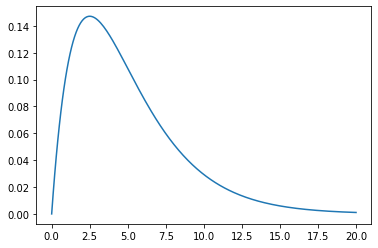

In [ ]:
import scipy.stats as stats 
import numpy as np
import matplotlib.pyplot as plt

alpha = 2
beta = 0.4
x = np.linspace (0, 20, 200) 
y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x,y1)